In [1]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt
from fontTools.ttLib import TTFont
from PIL import Image, ImageDraw, ImageFont, ImageChops
from tqdm import tqdm

import logging
logging.getLogger("fontTools").setLevel(logging.ERROR) # 只是想消除 '2 extra bytes in post.stringData array'


In [2]:
def compare_char_render(char_1: str, char_2: str, font_path1: str, font_path2: str, show_img: bool = False, similarity_threshold: float = 0.975) -> bool:
    """
    Render a character using two different fonts and compare if the generated images are sufficiently similar.
    
    Parameters:
      char_1: The character to render with the first font.
      char_2: The character to render with the second font.
      font_path1: File path for the first font.
      font_path2: File path for the second font.
      show_img: If True, display the images using matplotlib.
      similarity_threshold: Similarity threshold (0 - 1); if the similarity is above this threshold, the images are considered 'the same'.
      
    Returns:
      bool: True if the two images are sufficiently different, False if they are similar (or both fonts do not support the character).
    """
    canvas_size = 64   # Canvas size
    font_size = 48     # Font size

    # Load font 1 + 2 and check if it supports the character
    try:
        ttf1 = TTFont(font_path1)
        cmap1 = ttf1.getBestCmap()
        supported1 = {chr(code) for code in cmap1.keys()}
    except Exception as e:
        print(f"Failed to load font {font_path1}: {e}")
        supported1 = set()
    font1 = ImageFont.truetype(font_path1, font_size)
    
    try:
        ttf2 = TTFont(font_path2)
        cmap2 = ttf2.getBestCmap()
        supported2 = {chr(code) for code in cmap2.keys()}
    except Exception as e:
        print(f"Failed to load font {font_path2}: {e}")
        supported2 = set()
    font2 = ImageFont.truetype(font_path2, font_size)
    
    def render_char(font, char):
        img = Image.new("L", (canvas_size, canvas_size), color=255)
        draw = ImageDraw.Draw(img)
        # Calculate the bounding box of the character to center it
        bbox = draw.textbbox((0, 0), char, font=font)
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        x = (canvas_size - w) // 2 - bbox[0]
        y = (canvas_size - h) // 2 - bbox[1]
        draw.text((x, y), char, fill=0, font=font)
        return img

    # Render images for each font if the character is supported
    image1 = render_char(font1, char_1) if char_1 in supported1 else None
    image2 = render_char(font2, char_2) if char_2 in supported2 else None

    if show_img:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        if image1:
            axs[0].imshow(image1, cmap="gray")
            axs[0].set_title("Font1")
        else:
            axs[0].text(0.5, 0.5, "Not Supported", ha="center", va="center")
            axs[0].set_title("Font1")
        if image2:
            axs[1].imshow(image2, cmap="gray")
            axs[1].set_title("Font2")
        else:
            axs[1].text(0.5, 0.5, "Not Supported", ha="center", va="center")
            axs[1].set_title("Font2")
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    if image1 is None and image2 is None:
        return False
    if image1 is None or image2 is None:
        return True

    # Compute the difference between the two images
    diff = ImageChops.difference(image1, image2)
    # diff.getbbox() 为 None 时表示两幅图完全一致
    # are_different = diff.getbbox() is not None
    # return are_different

    # Convert the difference image to a numpy array and compute the average pixel difference (0 - 255)
    avg_diff = np.mean(np.array(diff))
    # Calculate similarity (1 indicates identical images)
    similarity = 1 - (avg_diff / 255)
    return similarity < similarity_threshold


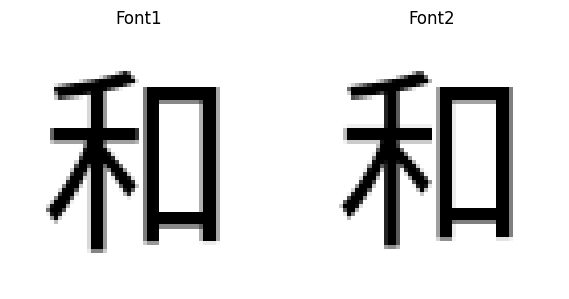

渲染 '和' 是否不一样：False


In [3]:
if __name__ == "__main__":
    SHS_CN = 'SourceHanSansCN-Regular.woff2'
    SHS_SC = 'SourceHanSansSC-Regular.woff2'
    # web_font = 'fixed.m8p286k7.woff2'
    web_font = 'randomFont_test.ttf'
    font1_path = os.path.join("fonts", SHS_SC)
    font2_path = os.path.join("temp", web_font)
    test_char_1 = "和"
    test_char_2 = "㑋"
    result = compare_char_render(test_char_1, test_char_2, font1_path, font2_path, show_img=True, similarity_threshold=0.975)
    print(f"渲染 '{test_char_1}' 是否不一样：{result}")


In [ ]:
def worker(args):
    char_code, font1_path, font2_path, replace_map, similarity_threshold = args
    original_char = chr(char_code)
    char_1 = replace_map.get(original_char, original_char)
    char_2 = original_char
    return compare_char_render(char_1, char_2, font1_path, font2_path, similarity_threshold)


if __name__ == "__main__":
    SHS_SC = 'SourceHanSansSC-Regular.woff2'
    web_randfont = 'randomFont_test.ttf'
    web_fixfont = 'fixed.m8p286k7.woff2'
    font1_path = os.path.join("fonts", SHS_SC)
    web_randfont_path = os.path.join("temp", web_randfont)
    web_fixfont_path = os.path.join("temp", web_fixfont)
    replace_map_path = os.path.join("output", "829661174", "font_mapping.json")
    if os.path.exists(replace_map_path):
        with open(replace_map_path, "r", encoding="utf-8") as f:
            replace_map = json.load(f)
    else:
        replace_map = {}
    
    similarity_threshold = 0.975
    total_count = 0
    diff_count = 0

    # Process Unicode range U+3400 to U+4DB5 (inclusive) using the random font
    # for code in range(0x3400, 0x4DB6):
    for code in tqdm(range(0x3400, 0x4DB6), desc="Processing U+3400-U+4DB5"):
        original_char = chr(code)
        # Use replacement mapping if available for the first font's character
        char_1 = replace_map.get(original_char, original_char)
        char_2 = original_char
        
        result = compare_char_render(char_1, char_2, font1_path, web_randfont_path, show_img=False, similarity_threshold=similarity_threshold)
        total_count += 1
        if result:
            diff_count += 1
    
    # Process Unicode range U+4E00 to U+9FA5 (inclusive) using the fixed web font
    # for code in range(0x4E00, 0x9FA6):
    for code in tqdm(range(0x4E00, 0x9FA6), desc="Processing U+4E00-U+9FA5"):
        original_char = chr(code)
        char_1 = replace_map.get(original_char, original_char)
        char_2 = original_char
        
        result = compare_char_render(char_1, char_2, font1_path, web_fixfont_path, show_img=False, similarity_threshold=similarity_threshold)
        total_count += 1
        if result:
            diff_count += 1
    
    # Print summary statistics
    print(f"Total characters processed: {total_count}")
    print(f"Different renders count: {diff_count}")
    if total_count > 0:
        print(f"Difference ratio: {diff_count/total_count:.2%}")

